In [ ]:
import pymysql
import pandas as pd

#подключение к базе данных
def get_connection():
    connection = pymysql.connect(host='database-3.chim8btj05zt.us-east-1.rds.amazonaws.com',
                                 user='admin',
                                 password='01035007',
                                 db='test',
                                 charset='utf8mb4',
                                 cursorclass=pymysql.cursors.DictCursor)
    return connection


connection = get_connection()

try:
    with connection.cursor() as cursor:
        print("выгрузка датасета")
        s = "SELECT count(*) AS count FROM sort_v2 WHERE ttype = -1"
        cursor.execute(s)
        c1 = cursor.fetchone()['count']
        s = "SELECT count(*) AS count FROM sort_v2 WHERE ttype = 1"
        cursor.execute(s)
        c2 = cursor.fetchone()['count']
        min_c = min(c1, c2)

        s = "SELECT ttext_stem, ttype FROM sort_v2 WHERE ttype = -1 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_n = pd.DataFrame(result)
        print(data_n.head(5))
        s = "SELECT ttext_stem, ttype FROM sort_v2 WHERE ttype = 1 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_p = pd.DataFrame(result)
        print(data_p.head(5))

        raw_data = pd.concat([data_p, data_n], ignore_index = True)
        raw_data = raw_data.sample(frac=1).reset_index(drop=True)  
        print(f"Обучающий набор: {raw_data.shape}")

        print("выгрузка тестовых данных")
        s = "SELECT count(*) AS count FROM linis_texts WHERE ttype = -1 OR ttype = -2"
        cursor.execute(s)
        c1 = cursor.fetchone()['count']
        s = "SELECT count(*) AS count FROM linis_texts WHERE ttype = 1 OR ttype = 2"
        cursor.execute(s)
        c2 = cursor.fetchone()['count']
        min_c = min(c1, c2)

        s = "SELECT ttext_stem, ttype FROM linis_texts WHERE ttype = -1 OR ttype = -2 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_n = pd.DataFrame(result)
        print(data_n.head(5))

        s = "SELECT ttext_stem, ttype FROM linis_texts WHERE ttype = 1 OR ttype = 2 LIMIT %s"
        cursor.execute(s, (min_c))
        result = cursor.fetchall()
        data_p = pd.DataFrame(result)
        print(data_p.head(5))

        test_data = pd.concat([data_p, data_n], ignore_index = True)
        #test_data = test_data.loc[test_data['ttype'] != 0]

        data_p = None
        data_n = None
        result = None

        test_data = test_data.sample(frac=1).reset_index(drop=True)  
        print(f"Тестовые данные: {test_data.shape}")
    
finally:
    connection.close()

выгрузка датасета
                                          ttext_stem  ttype
0  работа|полный|пиддес|равнодушие|скука|каждый|з...     -1
1  коллега|сидеть|рубиться|urban|terror|долбать|в...     -1
2                    user|говорят|обещаной|год|ждать     -1
3  желать|хороший|полёт|удачный|посадка|очень|сил...     -1
4  обновить|леший|surf|работать|простоплеер|груст...     -1
                                          ttext_stem  ttype
0  user|школотый|поверь|самый|смех|общество|профи...      1
1  весь|таки|немного|похожий|мальчик|весь|равно|х...      1
2                         rt|user|идиотка|испугаться      1
3  rt|user|угол|сидеть|погибать|голод|ещё|порция|...      1
4  user|значит|страшилка|смех|блин|посмотреть|вес...      1
Обучающий набор: (223846, 2)
выгрузка тестовых данных
                                          ttext_stem  ttype
0  htm|обсуждать|сайт|весь|рядовой|гражданин|жить...     -2
1  приватизация|это|первородный|грех|антикоммунис...     -2
2  обычный|дело|улыбка|шутка

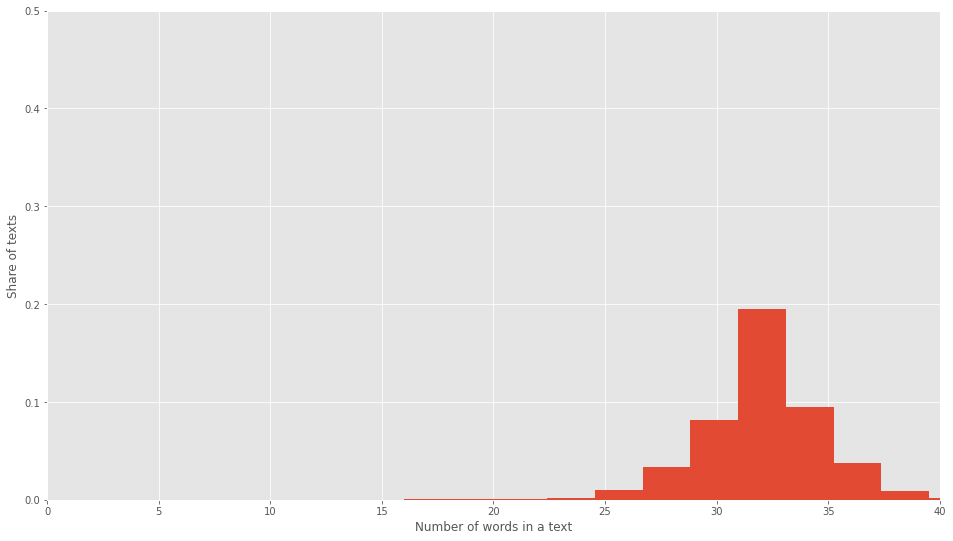

In [ ]:
#гистограмма наиболее часто встречающегося количества слов
import matplotlib.pyplot as plt

plt.style.use('ggplot')

plt.figure(figsize=(16, 9)) 
# facecolor='g'
len_of_sent = test_data['ttext_stem'].apply(lambda x: len(x.split('|')))
n, bins, patches = plt.hist(len_of_sent, 50, density=True)
plt.xlabel('Number of words in a text')
plt.ylabel('Share of texts')
plt.axis([0, 40, 0, 0.5])
plt.grid(True)
plt.show()

#больше всего предложений длиной 8 слов. выбираем количество анализируемых слов = 25

In [ ]:
#загрузка модели Word2Vec
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import numpy as np
from gensim.models import Word2Vec
from google.colab import drive

drive.mount('/gdrive')
model = Word2Vec.load("/gdrive/My Drive/Colab Notebooks/w2v_1000/model1000_iter_8.word2vec")
model.delete_temporary_training_data()

DIM = model.vector_size
tokenizer = Tokenizer()
tokenizer.fit_on_texts(model.wv.vocab.keys())

SENTENCE_LENGTH = 25

print("подготовка обучающего набора")
data = [row.split('|') for row in raw_data['ttext_stem']]
X = tokenizer.texts_to_sequences(data) 
X = pad_sequences(X, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X[0])}")
print(X)

Y = [1 if d == 1 else 0 for d in raw_data['ttype']]
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("подготовка тестового набора новостей")
test_d = [row.split('|') for row in test_data['ttext_stem']]
X_test2 = tokenizer.texts_to_sequences(test_d) 
X_test2 = pad_sequences(X_test2, maxlen=SENTENCE_LENGTH)
print(f"Количество слов в предложении: {len(X_test2[0])}")
print(X_test2)

Y_test2 = [1 if d == 1 or d == 2 else 0 for d in test_data['ttype']]
print(Y_test2)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


подготовка обучающего набора
Количество слов в предложении: 25
[[     0      0      0 ...     90   1030   1031]
 [     0      0      0 ...      6  12265 154310]
 [     0      0      0 ...    594    626    999]
 ...
 [     0      0      0 ...  28138   1030   1031]
 [     0      0      0 ...     25     26   1071]
 [     0      0      0 ...    223  10806  28154]]
[0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 

In [ ]:
'''
#загрузка модели Word2Vec
import numpy as np
from gensim.models import Word2Vec
from google.colab import drive
drive.mount('/gdrive')

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = Word2Vec.load("/gdrive/My Drive/Colab Notebooks/word2vec300/model300_iter_3.word2vec")

#дообучение модели на размеченной базе
model.build_vocab(data, update = True)
model.train(sentences=data, epochs=3, total_examples=model.corpus_count)
#model.delete_temporary_training_data()
model.save("/gdrive/My Drive/Colab Notebooks/word2vec300/model300_iter_3_plus.word2vec", sep_limit = 100 * 1024 ** 2)
'''
''' Убираем наполнение по tokenizer, так как может оказывать влияние на тесты
#загрузка слов из набора train
e_matrix = []
for word, i in tokenizer.word_index.items():
    count = tokenizer.word_counts[word]
    if word in model.wv.vocab.keys() and count < lim_1:
        e_matrix.append(model.wv[word])
print(f"Размерность словаря модели - {len(e_matrix)}")
'''
'''
#Обрезка часто встречающихся и редких слов
max_count = 0
for word in model.wv.vocab.keys():
    try:
        if tokenizer.word_counts[word] > max_count:
            max_count = tokenizer.word_counts[word]
    except:
        print("Пропущено слово при вычислении максимума")
        continue
print(f"Максимальное число встречаемости слова - {max_count}. Удаляем такие слова")
lim_2 = max_count * 0.1
lim_1 = 50
'''

'\n#Обрезка часто встречающихся и редких слов\nmax_count = 0\nfor word in model.wv.vocab.keys():\n    try:\n        if tokenizer.word_counts[word] > max_count:\n            max_count = tokenizer.word_counts[word]\n    except:\n        print("Пропущено слово при вычислении максимума")\n        continue\nprint(f"Максимальное число встречаемости слова - {max_count}. Удаляем такие слова")\nlim_2 = max_count * 0.1\nlim_1 = 50\n'

In [ ]:
#загрузка слов из словаря модели
e_matrix = []
for word in model.wv.vocab.keys():
    try:
        e_matrix.append(model.wv[word])
        if len(e_matrix) >= 300000:
            break
    except:
        print("Пропущено слово при заполнении модели")
        continue

print(f"Размерность словаря для embedding- {len(e_matrix)}")

NUM = len(e_matrix)
e_matrix = np.array(e_matrix, dtype=object)
print(e_matrix.shape)
print(e_matrix)

Размерность словаря для embedding- 181874
(181874, 1000)
[[-0.40454161167144775 0.12993285059928894 0.7127326130867004 ...
  0.10584969818592072 -0.8944813013076782 -0.6959888935089111]
 [-0.1578376591205597 0.10478681325912476 -0.30030837655067444 ...
  -0.28371313214302063 0.16417500376701355 0.3342585563659668]
 [0.7434800267219543 0.41508015990257263 1.604353666305542 ...
  0.48045238852500916 -1.240762710571289 0.10171331465244293]
 ...
 [-0.06994505971670151 0.0321773923933506 0.07513144612312317 ...
  -0.03570457920432091 0.06348524242639542 0.019250229001045227]
 [-0.002316100290045142 -0.06704910099506378 -0.0321541503071785 ...
  -0.0599646270275116 0.0416359081864357 0.019572574645280838]
 [-0.05430953577160835 -0.10703196376562119 0.03356761485338211 ...
  0.20355257391929626 0.0005478154052980244 -0.07364808768033981]]


In [ ]:
from keras import backend as K 

# Метрики 
def precision(y_true, y_pred):
    """Precision metric.

    Only computes a batch-wise average of precision.

    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    """Recall metric.

    Only computes a batch-wise average of recall.

    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [ ]:
from keras.layers import Input
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.layers import Dense, concatenate, Activation, Dropout
from keras.models import Model
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D

tweet_input = Input(shape=(SENTENCE_LENGTH,), dtype='int32') 
tweet_encoder = Embedding(NUM, DIM, input_length=SENTENCE_LENGTH, weights=[e_matrix], trainable=False)(tweet_input) #Слой Emdedding

branches = []

x = Dropout(0.2)(tweet_encoder)
for size, filters_count in [(2, 10), (3, 10), (4, 10), (5, 10)]:
    for i in range(filters_count):
        branch = Conv1D(filters=1, kernel_size=size, padding='valid', activation='relu')(x)
        branch = GlobalMaxPooling1D()(branch)
        branches.append(branch)
x = concatenate(branches, axis=1)
x = Dropout(0.2)(x)
x = Dense(30, activation='relu')(x)
x = Dense(1)(x)
output = Activation('sigmoid')(x)

model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', precision, recall, f1])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 1000)     181874000   input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 25, 1000)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 24, 1)        2001        dropout_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings_1-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Train on 143260 samples, validate on 35816 samples
Epoch 1/10
143260/143260 [==============================] - 266s 2ms/step - loss: 0.3931 - accuracy: 0.7832 - precision: 0.7919 - recall: 0.7727 - f1: 0.7747 - val_loss: 0.3520 - val_accuracy: 0.8118 - val_precision: 0.7980 - val_recall: 0.8335 - val_f1: 0.8103
Epoch 2/10
143260/143260 [==============================] - 262s 2ms/step - loss: 0.3580 - accuracy: 0.8106 - precision: 0.8148 - recall: 0.8058 - f1: 0.8042 - val_loss: 0.3445 - val_accuracy: 0.8187 - val_precision: 0.7986 - val_recall: 0.8491 - val_f1: 0.8183
Epoch 3/10
143260/143260 [==============================] - 267s 2ms/step - loss: 0.3398 - accuracy: 0.8246 - precision: 0.8268 - recall: 0.8225 - f1: 0.8191 - val_loss: 0.3449 - val_accuracy: 0.8176 - val_precision: 0.8613 - val_recall: 0.7556 - val_f1: 0.7994
Epoch 4/10
143260/143260 [======================

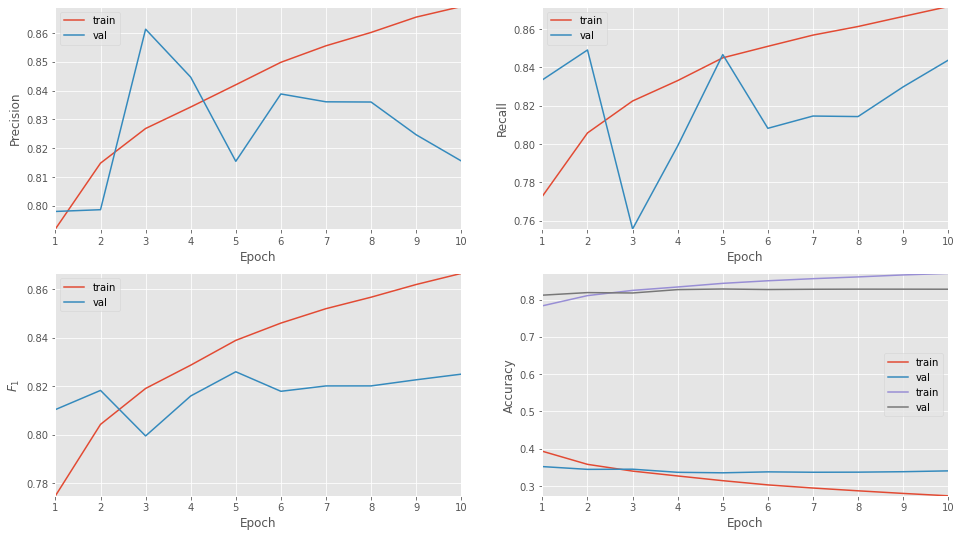

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings_1-05-0.83.hdf5')

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора твитов:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))
print("Оценки тестового набора новостей:")
predicted = np.round(model.predict(X_test2))
print(classification_report(Y_test2, predicted, digits=3))

Оценки тестового набора твитов:
              precision    recall  f1-score   support

           0      0.834     0.806     0.820     22245
           1      0.814     0.842     0.828     22525

    accuracy                          0.824     44770
   macro avg      0.824     0.824     0.824     44770
weighted avg      0.824     0.824     0.824     44770

Оценки тестового набора новостей:
              precision    recall  f1-score   support

           0      0.571     0.279     0.374      4515
           1      0.523     0.790     0.629      4515

    accuracy                          0.534      9030
   macro avg      0.547     0.534     0.502      9030
weighted avg      0.547     0.534     0.502      9030



In [ ]:
from keras.callbacks import ModelCheckpoint
from google.colab import drive
drive.mount('/gdrive')
checkpoint = ModelCheckpoint("/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings_2-{epoch:02d}-{val_f1:.2f}.hdf5", # Сохраняем модель с лучшим val_f1
                             monitor='val_f1', save_best_only=True, mode='max', period=1)
history = model.fit(X_train, Y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks = [checkpoint])

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
Train on 143260 samples, validate on 35816 samples
Epoch 1/10
143260/143260 [==============================] - 261s 2ms/step - loss: 0.3046 - accuracy: 0.8490 - precision: 0.8478 - recall: 0.8511 - f1: 0.8449 - val_loss: 0.3354 - val_accuracy: 0.8295 - val_precision: 0.8348 - val_recall: 0.8196 - val_f1: 0.8222
Epoch 2/10
143260/143260 [==============================] - 265s 2ms/step - loss: 0.2944 - accuracy: 0.8564 - precision: 0.8540 - recall: 0.8604 - f1: 0.8530 - val_loss: 0.3366 - val_accuracy: 0.8257 - val_precision: 0.8294 - val_recall: 0.8172 - val_f1: 0.8182
Epoch 3/10
143260/143260 [==============================] - 252s 2ms/step - loss: 0.2868 - accuracy: 0.8618 - precision: 0.8614 - recall: 0.8626 - f1: 0.8577 - val_loss: 0.3393 - val_accuracy: 0.8267 - val_precision: 0.8162 - val_recall: 0.8404 - val_f1: 0.8232
Epoch 4/10
143260/143260 [======================

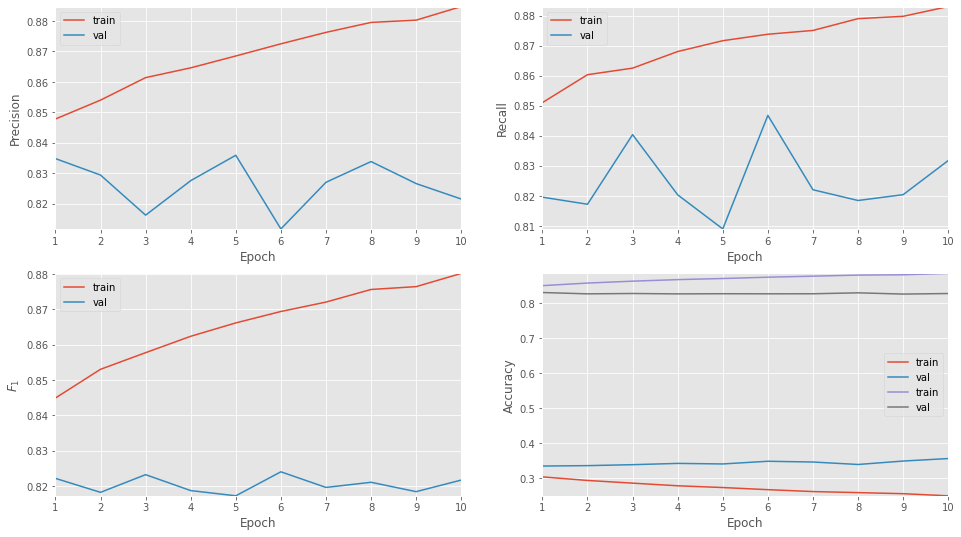

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
model.load_weights('/gdrive/My Drive/Colab Notebooks/cnn-frozen-embeddings_1-05-0.83.hdf5')

OSError: ignored

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора твитов:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))
print("Оценки тестового набора новостей:")
predicted = np.round(model.predict(X_test2))
print(classification_report(Y_test2, predicted, digits=3))

In [ ]:
from keras import optimizers

model.layers[1].trainable = True
adam = optimizers.Adam(lr=0.0001)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy', precision, recall, f1])
model.summary()# Модель с размороженным emdedding

In [ ]:
checkpoint = ModelCheckpoint("cnn-trainable-{epoch:02d}-{val_f1:.2f}.hdf5", 
                             monitor='val_f1', save_best_only=True, mode='max', period=1)

history_trainable = model.fit(X_train, Y_train, batch_size=32, epochs=5, validation_split=0.25, callbacks = [checkpoint])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')


def plot_metrix(ax, x1, x2, title):
    ax.plot(range(1, len(x1) + 1), x1, label='train')
    ax.plot(range(1, len(x2) + 1), x2, label='val')
    ax.set_ylabel(title)
    ax.set_xlabel('Epoch')
    ax.legend()
    ax.margins(0)


def plot_history(history):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16, 9))
    ax1, ax2, ax3, ax4 = axes.ravel()

    plot_metrix(ax1, history.history['precision'], history.history['val_precision'], 'Precision')
    plot_metrix(ax2, history.history['recall'], history.history['val_recall'], 'Recall')
    plot_metrix(ax3, history.history['f1'], history.history['val_f1'], "$F_1$")
    plot_metrix(ax4, history.history['loss'], history.history['val_loss'], 'Loss')
    plot_metrix(ax4, history.history['accuracy'], history.history['val_accuracy'], 'Accuracy')

    plt.show()


plot_history(history)

In [ ]:
model.load_weights('cnn-trainable-____.hdf5')

In [ ]:
from sklearn.metrics import classification_report
print("Оценки тестового набора твитов:")
predicted = np.round(model.predict(X_test))
print(classification_report(Y_test, predicted, digits=3))
print("Оценки тестового набора новостей:")
predicted = np.round(model.predict(X_test2))
print(classification_report(Y_test2, predicted, digits=3))